### Experiments

In [5]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from  torch.utils.data import Dataset
from PIL import Image

In [3]:
"""
Directory Structure : 
data/
    Images/
        img_dir/
            train/
                00000000.jpg
                00000001.jpg
                ...
            test/
                00000000.jpg
        ann_dir/
            train/
                00000000.png
                00000001.png
                ...
            test/
                00000000.png
                00000001.png
                ...

"""

'\nDirectory Structure : \ndata/\n    Images/\n        img_dir/\n            train/\n                00000000.jpg\n                00000001.jpg\n                ...\n            test/\n                00000000.jpg\n        ann_dir/\n            train/\n                00000000.png\n                00000001.png\n                ...\n            test/\n                00000000.png\n                00000001.png\n                ...\n\n'

<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


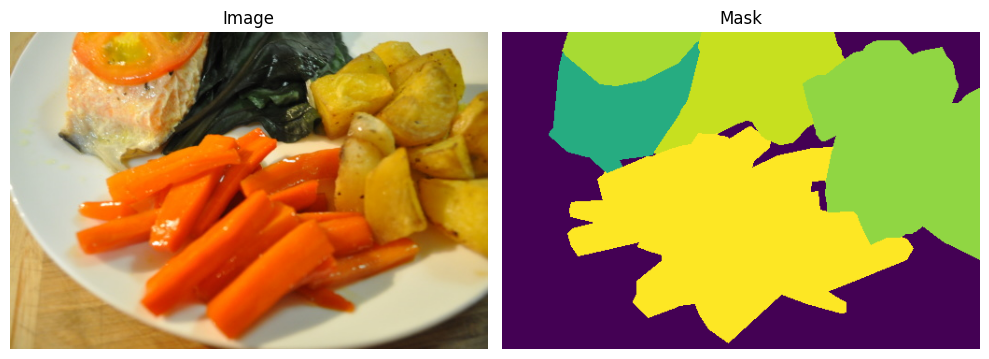

In [2]:
class FoodSegDataset(Dataset):
    def __init__(self, base_dir, mode='train', transforms=None , ann_transform=None):
        self.base_dir = base_dir
        self.mode = mode  # 'train' or 'test'
        
        self.img_dir = os.path.join(base_dir, "Images", "img_dir", mode)
        self.ann_dir = os.path.join(base_dir, "Images", "ann_dir", mode)

        self.transforms = transforms
        self.ann_transform = ann_transform
        self.images = os.listdir(self.img_dir)
        self.annotations = os.listdir(self.ann_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.images[idx])
        ann_name = os.path.join(self.ann_dir, self.images[idx].replace('.jpg', '.png'))  # ensure extension matches
        
        # Load image
        image = Image.open(img_name).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        
        # Load mask
        mask = Image.open(ann_name).convert("L")
        if self.ann_transform:
            mask = self.ann_transform(mask)

        return image, mask

    
    
data = FoodSegDataset(
    base_dir="/home/krrish/home/desktop/sarengeyo/food103seg-calories/data",
    mode='train',
)

image, mask = data[2]
print(type(image), type(mask))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show image (grayscale)
axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis('off')

# Show mask (binary or grayscale)
axes[1].imshow(mask)
axes[1].set_title("Mask")
axes[1].axis('off')

plt.tight_layout()
plt.show()



In [3]:
def data_loaders(base_dir, batch_size, num_workers=4):
        
       
        ann_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.PILToTensor(),
            transforms.Lambda(lambda x: x.squeeze().long()),
            transforms.Lambda(lambda x: torch.where(x >= 104, torch.tensor(0, dtype=torch.long), x)),
        ])
        

        img_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # converts PIL to float tensor and scales to [0, 1]
        ])

        # Create the dataset
        train_dataset = FoodSegDataset(base_dir, mode='train', transforms=img_transform , ann_transform=ann_transform)
        test_dataset = FoodSegDataset(base_dir, mode='test', transforms=img_transform , ann_transform=ann_transform)

        # DataLoaders 
        train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=num_workers
        )
        
    
        test_loader = torch.utils.data.DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=num_workers
        )
        
        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")
        
        return train_loader, test_loader



In [5]:
base_dir = "/home/krrish/home/desktop/sensor-behaviour/data"
train_loader, test_loader = data_loaders(base_dir = base_dir, batch_size=32, num_workers=4)
image, mask = next(iter(train_loader))
print(f"Batch size: {image.size(0)}")
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Image min: {image.min()}, max: {image.max()}")
print(f"Mask min: {mask.min()}, max: {mask.max()}")

Train dataset size: 4983
Test dataset size: 2135


Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Mask shape: torch.Size([32, 224, 224])
Image min: 0.0, max: 1.0
Mask min: 0, max: 103


In [6]:
def check_masks_for_invalid_values(data_loader, min_val=0, max_val=103):
    for i, (_, masks) in enumerate(data_loader):
        if masks.dim() == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)
        
        if (masks > max_val).any():
            print(f"Batch {i} contains mask pixels > {max_val}")
            invalid_pixels = (masks > max_val).nonzero(as_tuple=False)
            print(f"Invalid pixel positions: {invalid_pixels}")
            return True
        
        if (masks < min_val).any():
            print(f"Batch {i} contains mask pixels < {min_val}")
            invalid_pixels = (masks < min_val).nonzero(as_tuple=False)
            print(f"Invalid pixel positions: {invalid_pixels}")
            return True

    print(f"No masks contain pixel values outside range [{min_val}, {max_val}]")
    return False

# Usage example:
check_masks_for_invalid_values(test_loader, min_val=0, max_val=103)


No masks contain pixel values outside range [0, 103]


False

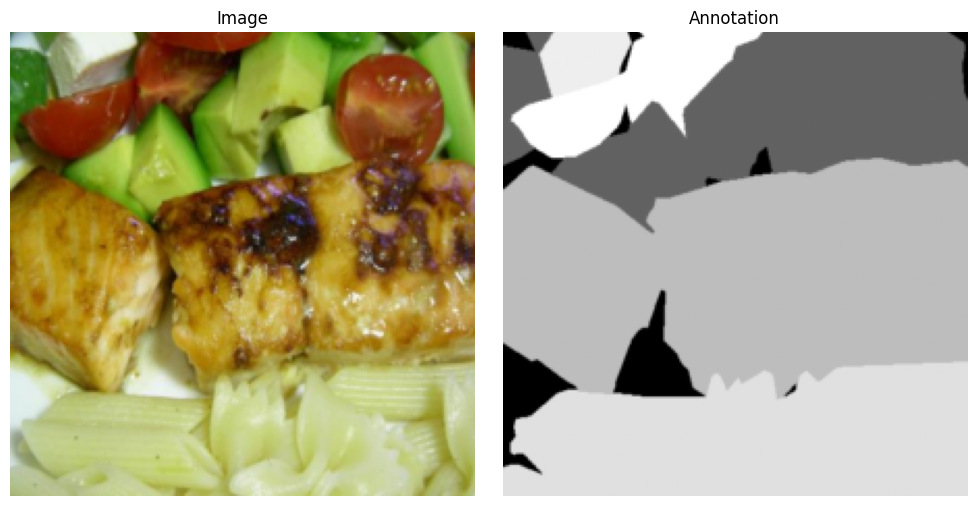

In [8]:
import matplotlib.pyplot as plt

image, annotation = next(iter(test_loader))

# Pick the second image in batch (index 1)
img = image[1]  # shape [3, H, W]
mask = annotation[1]  # shape [1, H, W]

# Convert image to HWC for imshow
img_np = img.permute(1, 2, 0).cpu().numpy()

# If image values are floats in [0,1], convert to uint8 0-255
if img_np.max() <= 1.0:
    img_np = (img_np * 255).astype('uint8')

# Mask: squeeze channel dim to get (H, W)
mask_np = mask.squeeze(0).cpu().numpy()

fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(img_np)
axis[0].set_title("Image")
axis[0].axis('off')

axis[1].imshow(mask_np, cmap='gray')
axis[1].set_title("Annotation")
axis[1].axis('off')

plt.tight_layout()
plt.show()


In [9]:
class FoodSegmentation(nn.Module):
    def __init__(self):
        super(FoodSegmentation, self).__init__()
        
        # Using Sequential for conv blocks to make code cleaner
        def conv_block(in_channels, out_channels):   #using two conv2d layer increases the receptive field
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        
        # Bottleneck
        self.bottleneck = conv_block(256, 512)
        
        # Decoder
        self.decoder1 = conv_block(512, 256)
        self.decoder2 = conv_block(256, 128)
        self.decoder3 = conv_block(128, 64)
        
        # Pooling and upsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  #upsampling
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        # Final layer
        self.final = nn.Sequential(
            nn.Conv2d(64, 104, kernel_size=1),
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))
        
        # Decoder with skip connections
        dec1 = self.decoder1(torch.cat([self.upconv1(bottleneck), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([self.upconv2(dec1), enc2], dim=1))
        dec3 = self.decoder3(torch.cat([self.upconv3(dec2), enc1], dim=1))
        
        return self.final(dec3)
    
model1 = FoodSegmentation()
# Create a dummy input: batch size=1, 3 channels, 224x224 image
dummy_input = torch.randn(64, 3, 224, 224)

# Pass through the model
output = model1(dummy_input)

# Print shapes
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
type(output)

Input shape: torch.Size([64, 3, 224, 224])
Output shape: torch.Size([64, 104, 224, 224])


torch.Tensor

In [10]:
from tqdm import tqdm

def train_model(model, train_loader, test_loader, num_epochs=1, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device).long()  # Ensure masks are long for CrossEntropyLoss
            # print(f"Mask min: {masks.min()}, max: {masks.max()}")

            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)  # [B, num_classes=3, H, W]
        
            
            loss = criterion(outputs, masks.long())  # masks should be long for CrossEntropyLoss
            loss.backward() 
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            train_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device).long()  # Ensure masks are long for CrossEntropyLoss
                if masks.dim() == 4 and masks.size(1) == 1:
                    masks = masks.squeeze(1)

                outputs = model(images)
                
                loss = criterion(outputs, masks.long())
                val_loss += loss.item() * images.size(0)
                val_bar.set_postfix(val_loss=loss.item())

        val_loss /= len(test_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

    print("Training complete.")
    return model


In [10]:
os.chdir("/home/krrish/home/desktop/sarengeyo/food103seg-calories/")

base_dir = "/home/krrish/home/desktop/sarengeyo/food103seg-calories/"

In [14]:
model = FoodSegmentation()
train_loader, test_loader = data_loaders(base_dir=os.path.join(base_dir, "data"), batch_size=64, num_workers=4)
model = train_model(model, train_loader, test_loader, num_epochs=20)
torch.save(model.state_dict(), os.path.join(base_dir, "saved", "model", "model.pth"))


Train dataset size: 4983
Test dataset size: 2135


Epoch 1/20 [Train]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch [1/20], Training Loss: 3.6958


Epoch [1/20], Validation Loss: 2.9290


Epoch [2/20], Training Loss: 2.7798


Epoch [2/20], Validation Loss: 2.7121


Epoch [3/20], Training Loss: 2.6657


Epoch [3/20], Validation Loss: 2.6532


Epoch [4/20], Training Loss: 2.6191


Epoch [4/20], Validation Loss: 2.6237


Epoch [5/20], Training Loss: 2.5898


Epoch [5/20], Validation Loss: 2.5883


Epoch [6/20], Training Loss: 2.5527


Epoch [6/20], Validation Loss: 2.5517


Epoch [7/20], Training Loss: 2.5139


Epoch [7/20], Validation Loss: 2.5225


Epoch [8/20], Training Loss: 2.4730


Epoch [8/20], Validation Loss: 2.4760


Epoch [9/20], Training Loss: 2.4413


Epoch [9/20], Validation Loss: 2.4500


Epoch [10/20], Training Loss: 2.4040


Epoch [10/20], Validation Loss: 2.4058


Epoch [11/20], Training Loss: 2.3708


Epoch [11/20], Validation Loss: 2.3846


Epoch [12/20], Training Loss: 2.3319


Epoch [12/20], Validation Loss: 2.3390


Epoch [13/20], Training Loss: 2.2961


Epoch [13/20], Validation Loss: 2.3210


Epoch [14/20], Training Loss: 2.2612


Epoch [14/20], Validation Loss: 2.2682


Epoch [15/20], Training Loss: 2.2302


Epoch [15/20], Validation Loss: 2.2449


Epoch [16/20], Training Loss: 2.2058


Epoch [16/20], Validation Loss: 2.2311


Epoch [17/20], Training Loss: 2.1849


Epoch [17/20], Validation Loss: 2.2011


Epoch [18/20], Training Loss: 2.1720


Epoch [18/20], Validation Loss: 2.1841


Epoch [19/20], Training Loss: 2.1599


Epoch [19/20], Validation Loss: 2.1793


Epoch [20/20], Training Loss: 2.1411


Epoch [20/20], Validation Loss: 2.1614
Training complete.


In [11]:
model = FoodSegmentation()
model.load_state_dict(torch.load(os.path.join(base_dir, "saved", "model", "model.pth")))
model.to('cuda' if torch.cuda.is_available() else 'cpu')

FoodSegmentation(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder1): Sequential(


In [16]:
images, masks = next(iter(train_loader))
predictions = model(images.to('cuda' if torch.cuda.is_available() else 'cpu'))

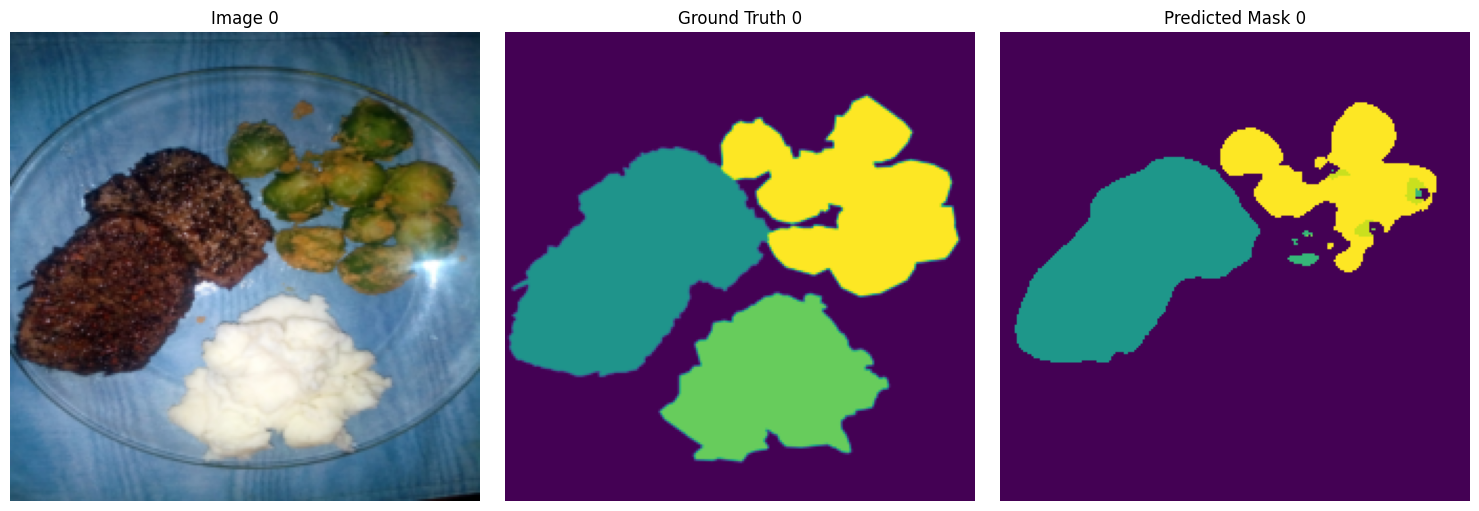

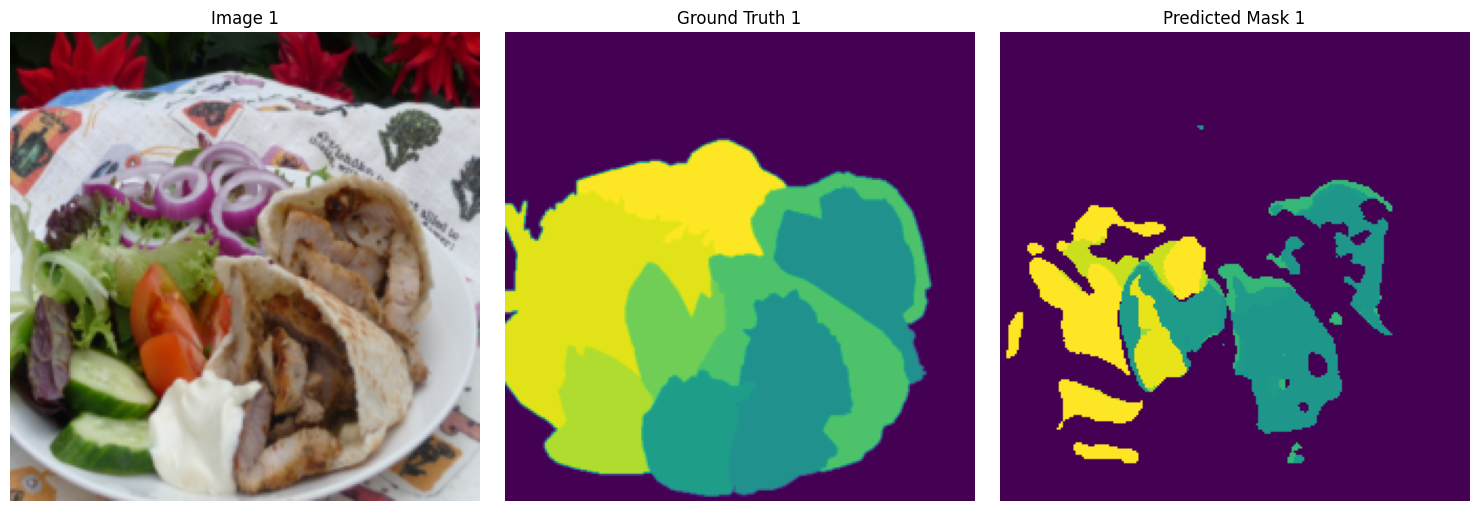

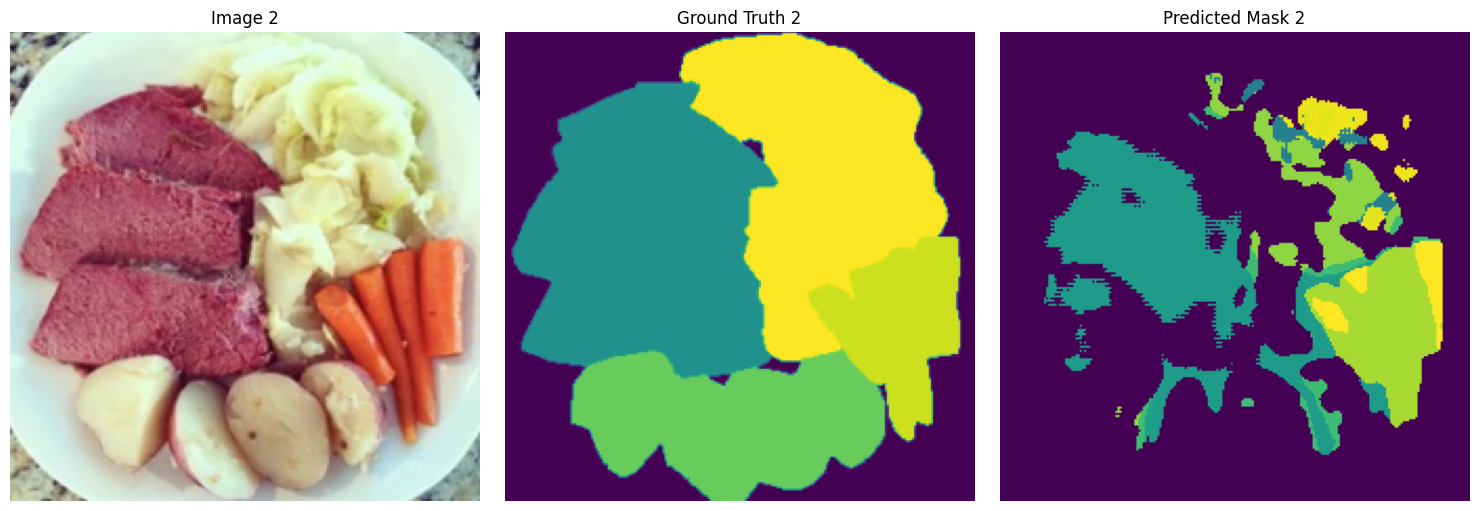

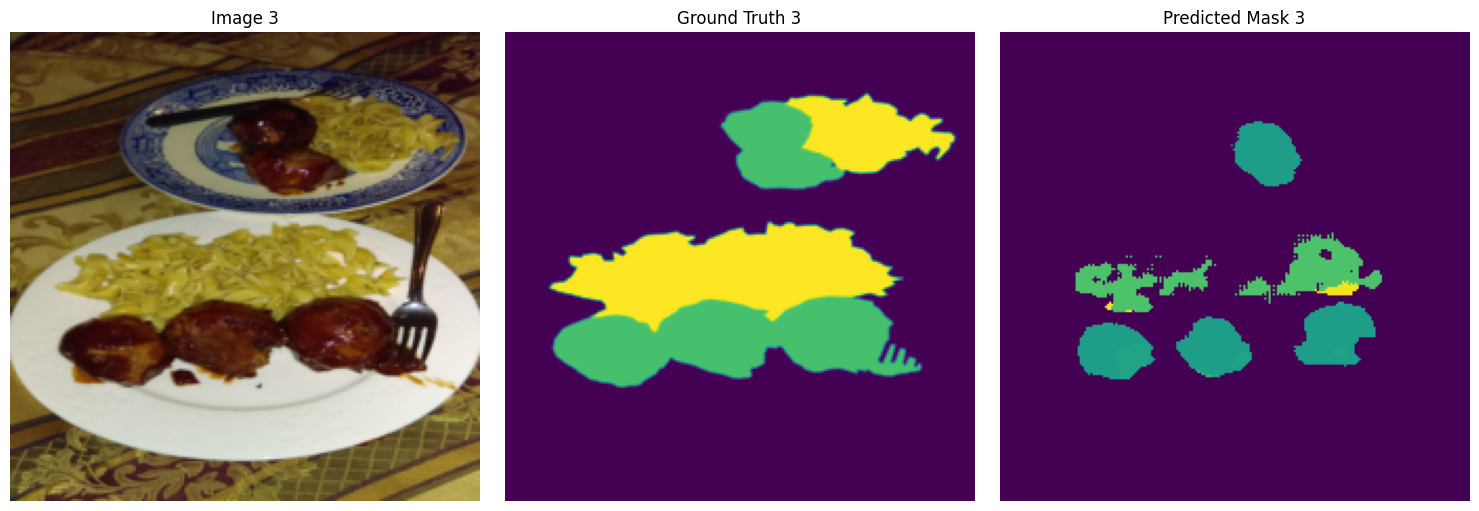

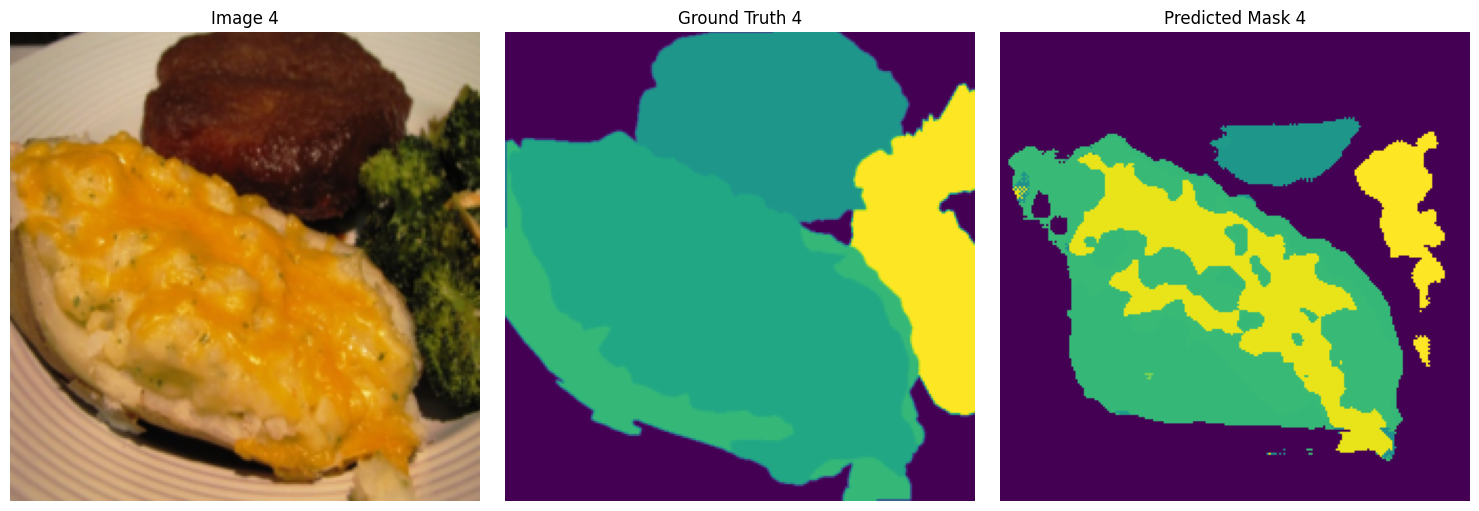

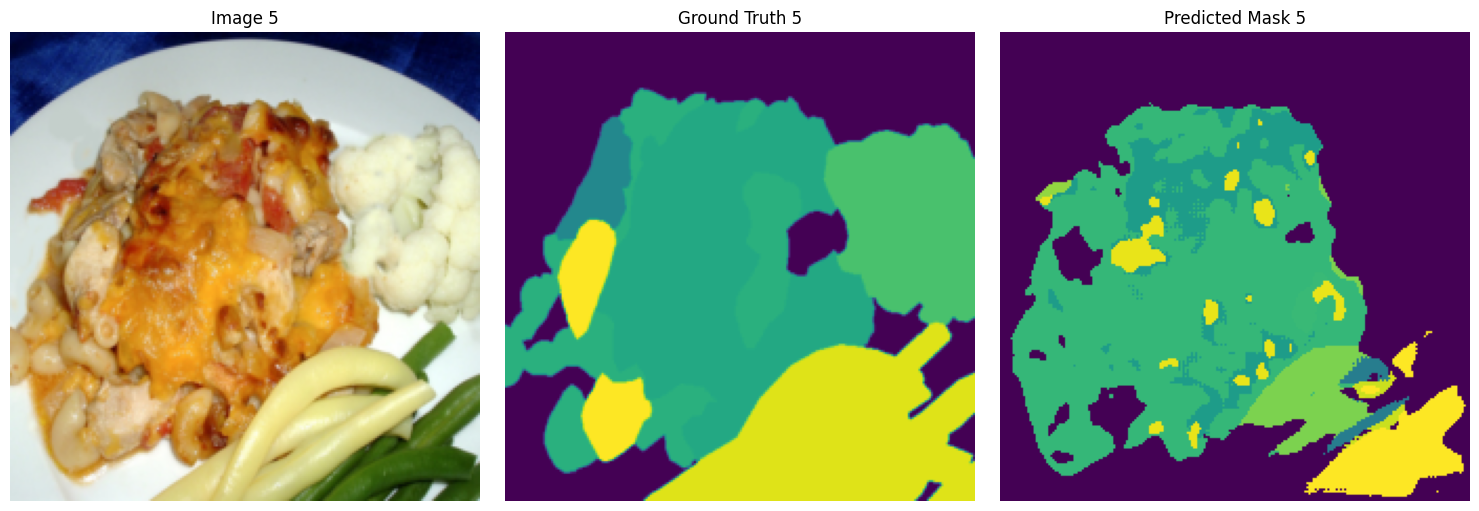

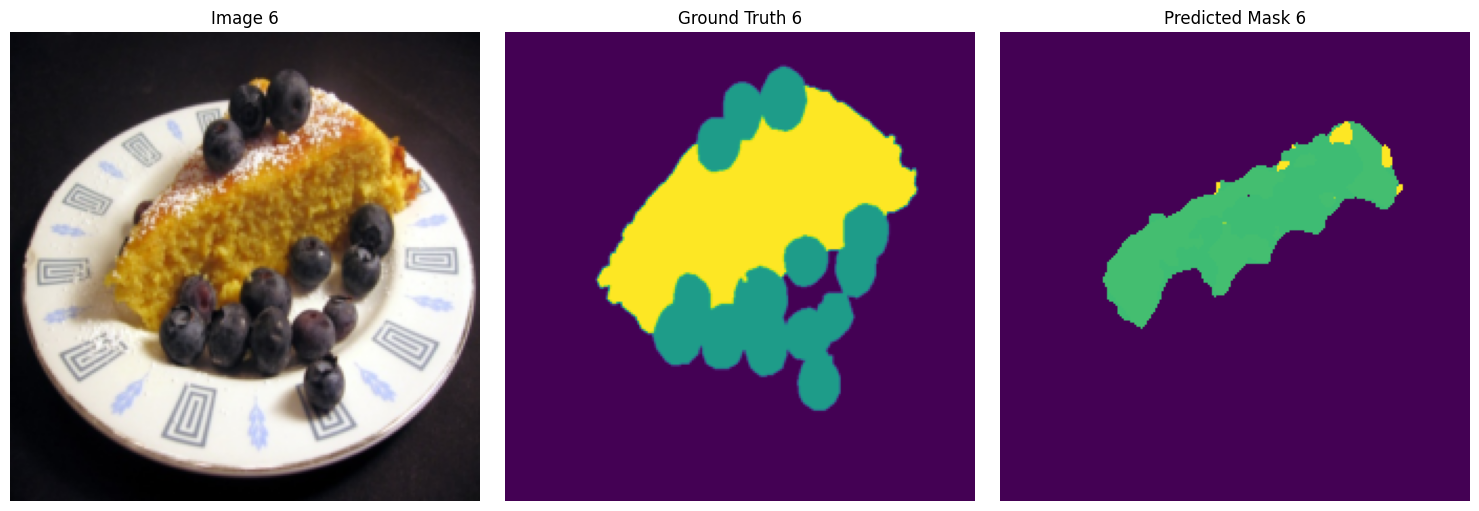

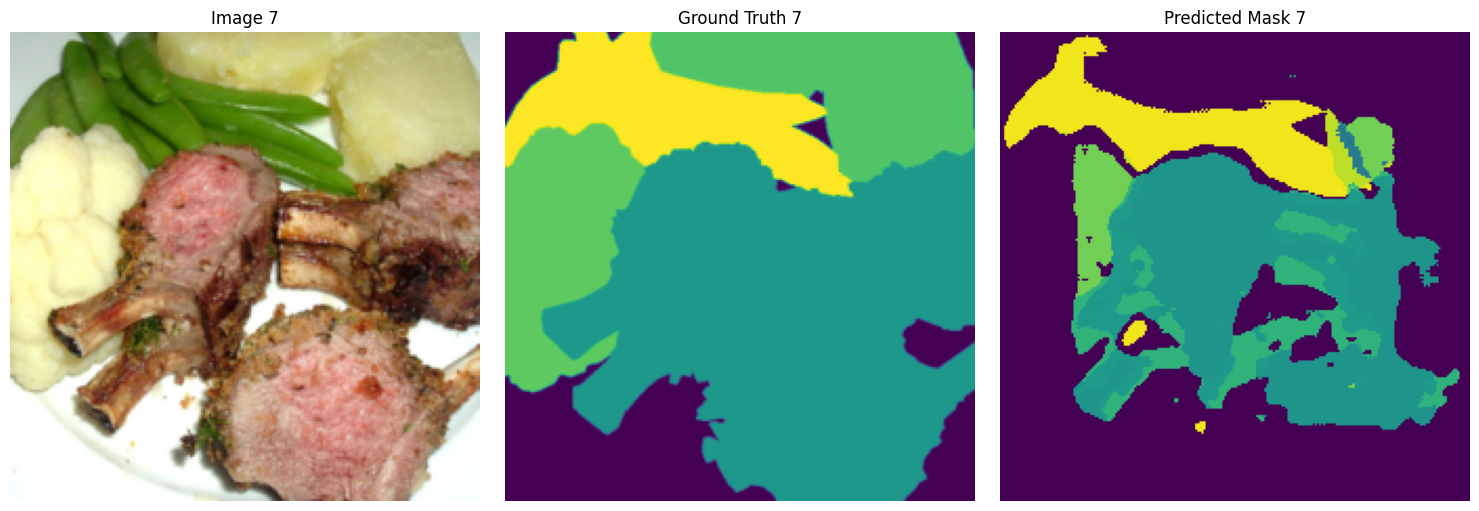

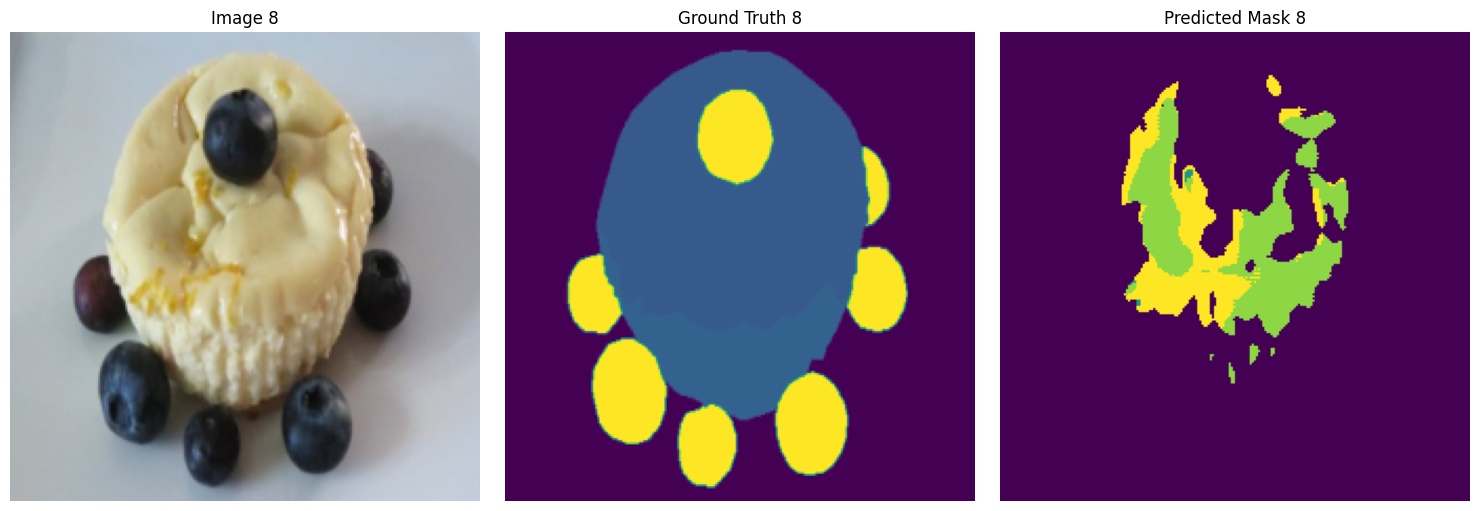

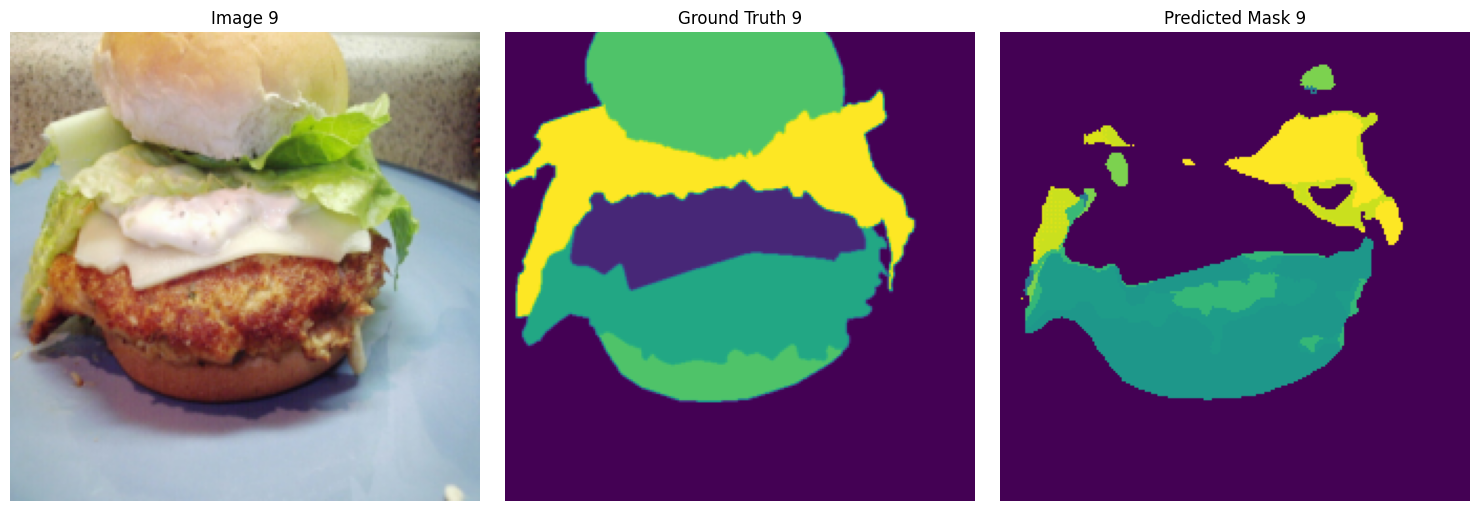

: 

In [ ]:
for i in range(10):  # 0 to 10
    fig, axis = plt.subplots(1, 3, figsize=(15, 5))
    
    # For RGB image: transpose from (3, 224, 224) to (224, 224, 3)
    axis[0].imshow(images[i].permute(1, 2, 0).numpy())
    axis[0].set_title(f"Image {i}")
    axis[0].axis('off')
    
    # For grayscale annotation: squeeze the channel dimension (1, 224, 224) to (224, 224)
    axis[1].imshow(masks[i].numpy())
    axis[1].set_title(f"Ground Truth {i}")
    axis[1].axis('off')
    
    # For predicted segmentation map: argmax over classes
    predicted_mask = predictions[i].argmax(dim=0).cpu().numpy()
    axis[2].imshow(predicted_mask)
    axis[2].set_title(f"Predicted Mask {i}")
    axis[2].axis('off')
    
    plt.tight_layout()
    plt.show()

Visualizing learned filters...
Filter weights shape: (64, 3, 3, 3)


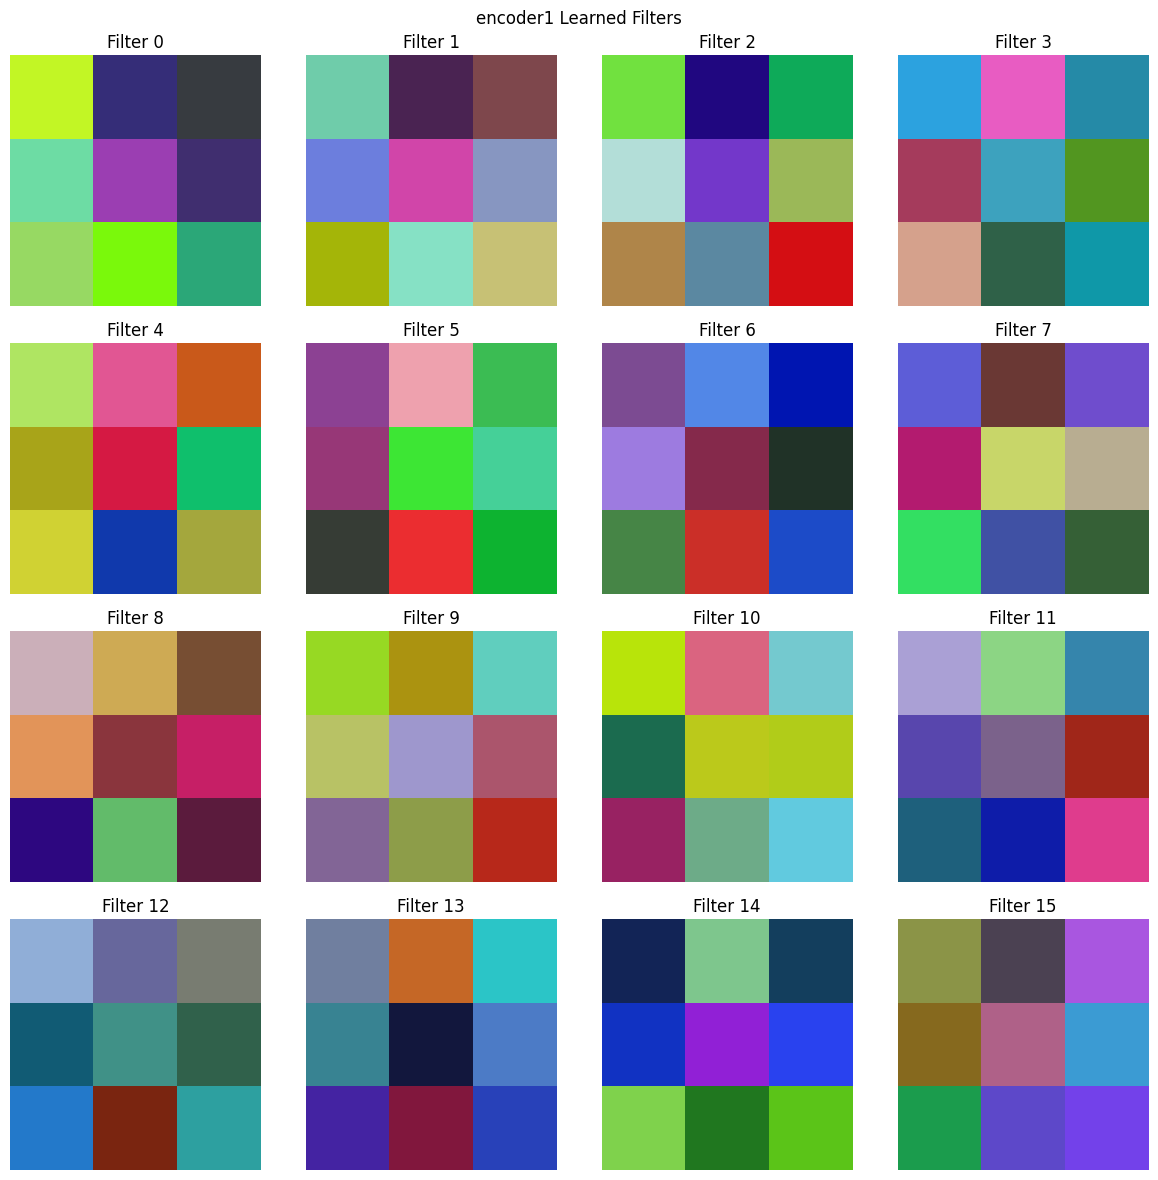

Filter weights shape: (128, 64, 3, 3)


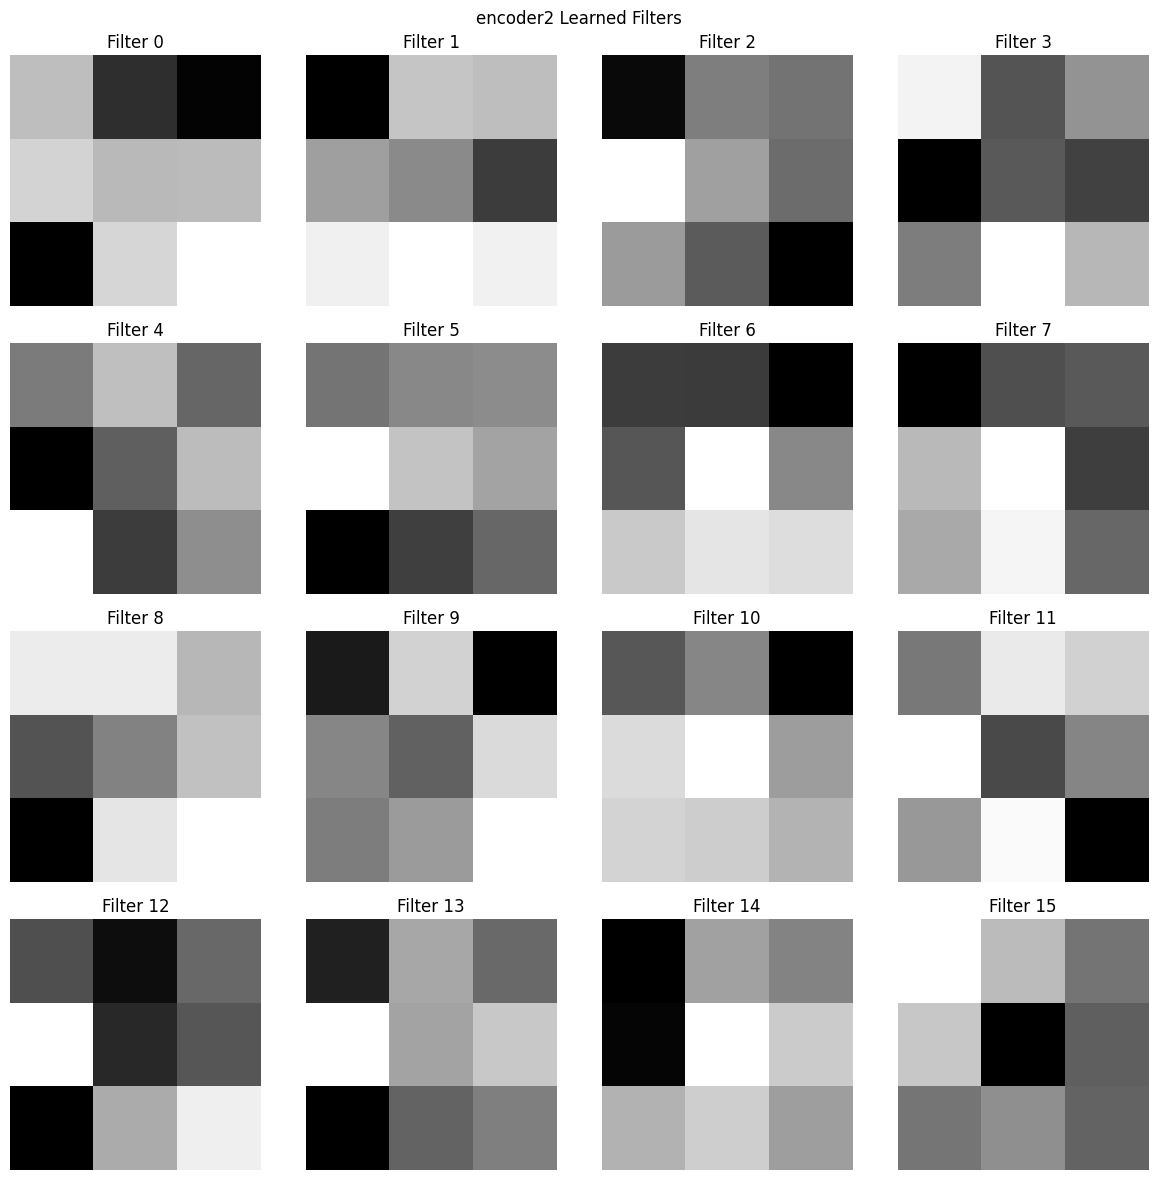

Filter weights shape: (256, 128, 3, 3)


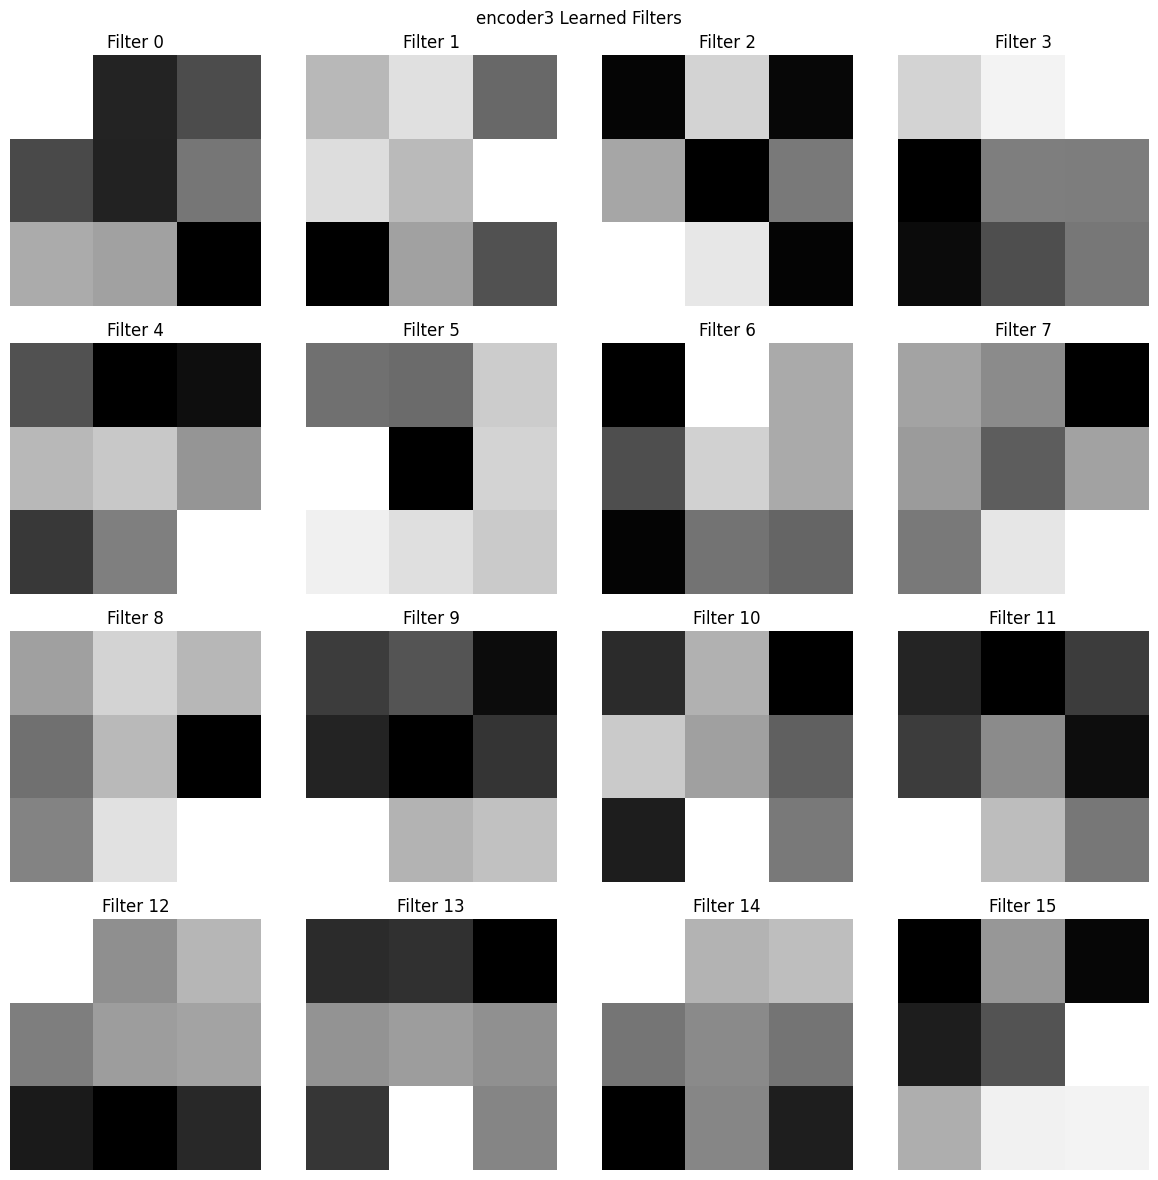


Visualizing feature maps...


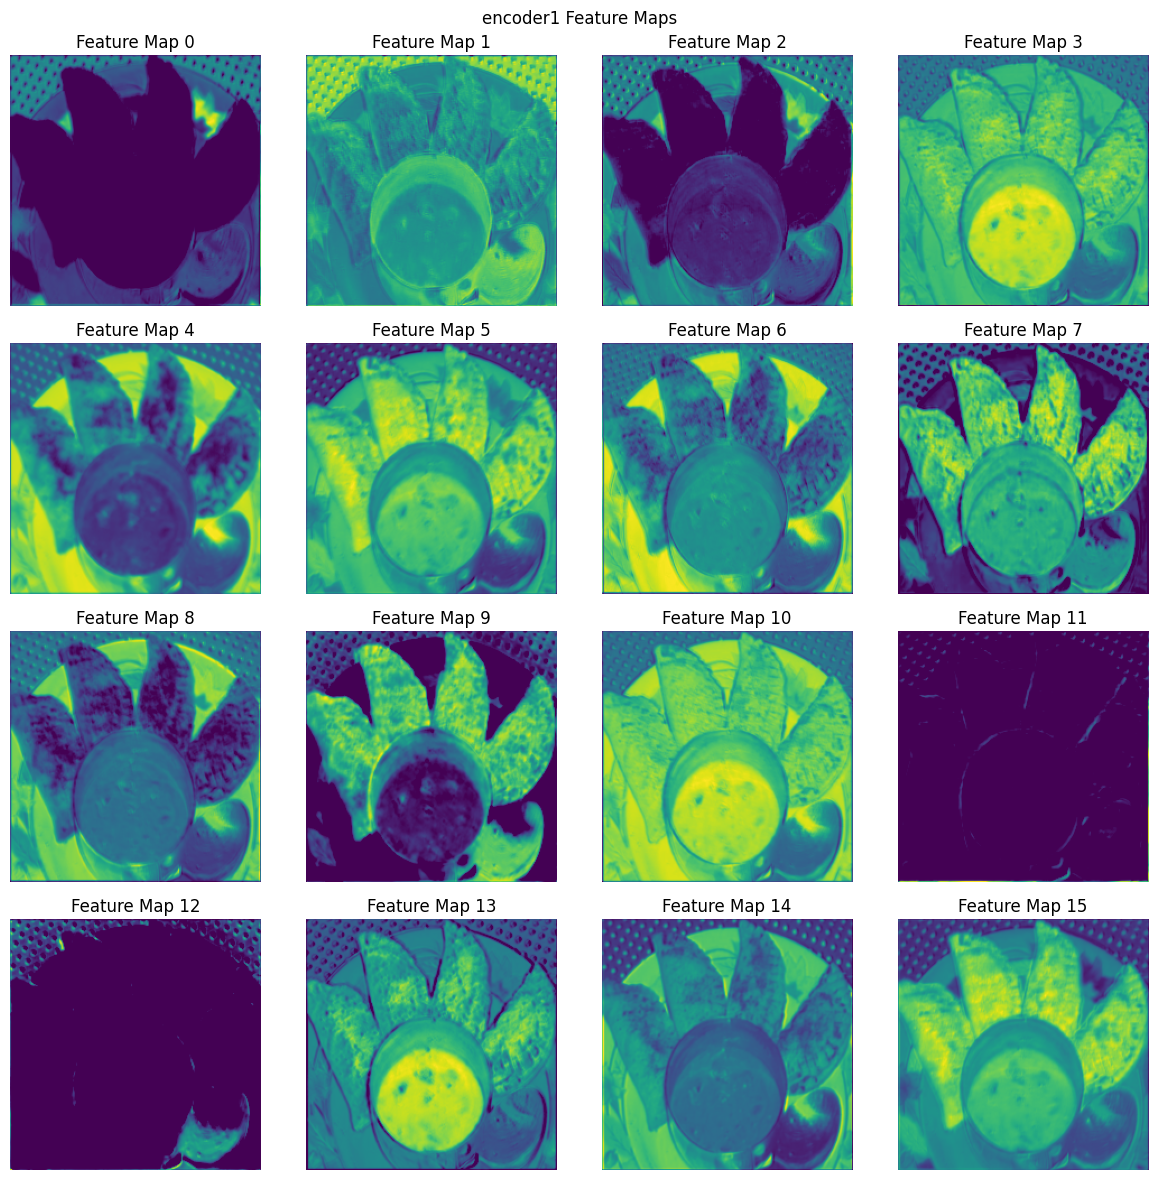

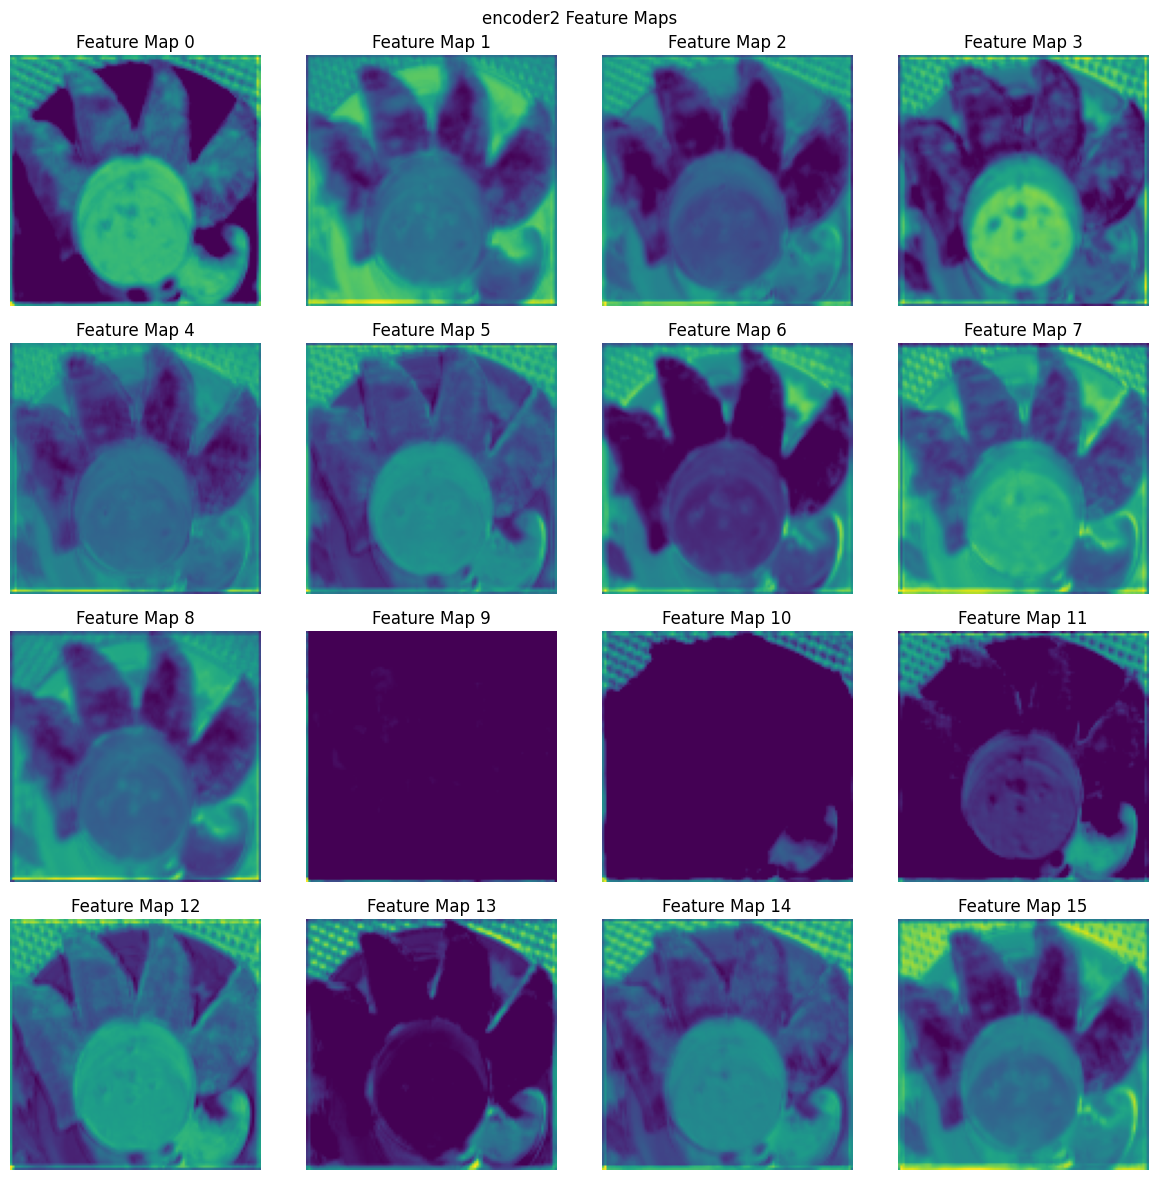

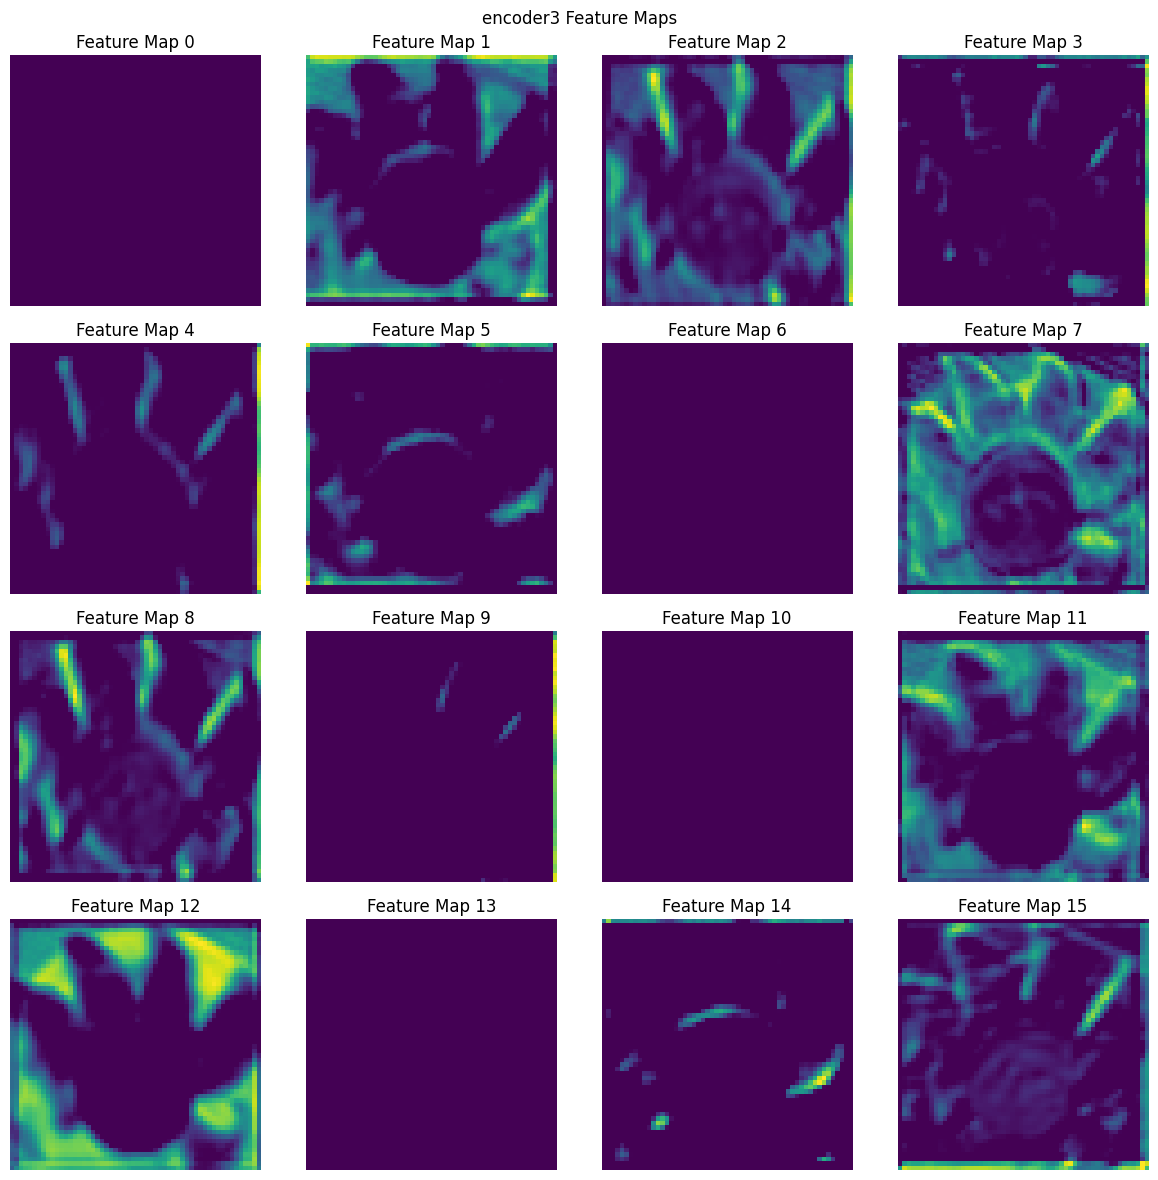

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize convolutional filters
def visualize_conv_filters(model, layer_name, num_filters=16):
    """Visualize the learned filters in a convolutional layer"""
    
    # Get the layer
    if layer_name == 'encoder1':
        layer = model.encoder1[0]  # First conv layer
    elif layer_name == 'encoder2':
        layer = model.encoder2[0]
    elif layer_name == 'encoder3':
        layer = model.encoder3[0]
    else:
        print(f"Layer {layer_name} not found")
        return
    
    # Get weights
    weights = layer.weight.data.cpu().numpy()
    print(f"Filter weights shape: {weights.shape}")
    
    # Normalize weights for visualization
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    
    # Plot filters
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(min(num_filters, weights.shape[0])):
        filter_img = weights[i]
        
        # If it's the first layer (RGB input), show as RGB
        if filter_img.shape[0] == 3:
            # Transpose from (3, H, W) to (H, W, 3)
            filter_img = np.transpose(filter_img, (1, 2, 0))
            axes[i].imshow(filter_img)
        else:
            # For deeper layers, show the first channel or average
            if filter_img.shape[0] > 1:
                filter_img = np.mean(filter_img, axis=0)
            else:
                filter_img = filter_img[0]
            axes[i].imshow(filter_img, cmap='gray')
        
        axes[i].set_title(f'Filter {i}')
        axes[i].axis('off')
    
    plt.suptitle(f'{layer_name} Learned Filters')
    plt.tight_layout()
    plt.show()

# Function to visualize feature maps
def visualize_feature_maps(model, input_image, layer_name, num_maps=16):
    """Visualize feature maps produced by a layer"""
    
    model.eval()
    
    # Hook to capture intermediate outputs
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    # Register hook
    if layer_name == 'encoder1':
        handle = model.encoder1.register_forward_hook(get_activation('encoder1'))
    elif layer_name == 'encoder2':
        handle = model.encoder2.register_forward_hook(get_activation('encoder2'))
    elif layer_name == 'encoder3':
        handle = model.encoder3.register_forward_hook(get_activation('encoder3'))
    else:
        print(f"Layer {layer_name} not found")
        return
    
    # Forward pass
    with torch.no_grad():
        _ = model(input_image.unsqueeze(0).to(model.final[0].weight.device))
    
    # Get feature maps
    feature_maps = activation[layer_name][0]  # First image in batch
    
    # Remove hook
    handle.remove()
    
    # Visualize feature maps
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(min(num_maps, feature_maps.shape[0])):
        feature_map = feature_maps[i].cpu().numpy()
        axes[i].imshow(feature_map, cmap='viridis')
        axes[i].set_title(f'Feature Map {i}')
        axes[i].axis('off')
    
    plt.suptitle(f'{layer_name} Feature Maps')
    plt.tight_layout()
    plt.show()

# Visualize filters from different layers
print("Visualizing learned filters...")

# First layer filters (should show edge detectors, color blobs)
visualize_conv_filters(model, 'encoder1', num_filters=16)

# Second layer filters (should show more complex patterns)
visualize_conv_filters(model, 'encoder2', num_filters=16)

# Third layer filters (should show even more complex patterns)
visualize_conv_filters(model, 'encoder3', num_filters=16)


images, _ = next(iter(test_loader))
# Visualize feature maps on a sample image
print("\nVisualizing feature maps...")
sample_image = images[9]  # Use first image from your batch

visualize_feature_maps(model, sample_image, 'encoder1', num_maps=16)
visualize_feature_maps(model, sample_image, 'encoder2', num_maps=16)
visualize_feature_maps(model, sample_image, 'encoder3', num_maps=16)

In [ ]:
import torch
import torch.nn as nn
import os
from loguru import logger
from src.segmentation.model import MiniUNet
from src.segmentation.data import data_loaders

# Logging into the files
logger.add("saved/logs/model_training.log", rotation="1 day")


# class FoodSegmentation(nn.Module):
#     def __init__(
#         self,
#         n_classes=104,
#         lr=1e-4,
#         base_dir="/home/krrish/home/desktop/sensor-behaviour/",
#         epochs=10,
#         batch_size=16,
#         validation_split=0.1,
#     ):

#         super().__init__()

#         self.n_classes = n_classes
#         self.model = MiniUnet(n_classes=n_classes).to(
#             "cuda" if torch.cuda.is_available() else "cpu"
#         )

#         # self.model = MobileNetV3DeepLabV3Plus().to(
#         #     "cuda" if torch.cuda.is_available() else "cpu"
#         # )

#         self.parameters = sum(
#             p.numel() for p in self.model.parameters() if p.requires_grad
#         )

#         # Training Parameters
#         self.epochs = epochs
#         self.lr = lr
#         self.batch_size = batch_size
#         self.validation_split = validation_split

#         # Base Directory
#         self.base_dir = os.path.join(base_dir, "data")

#         # Data Loaders
#         self.train_loader, self.val_loader, self.test_loader = data_loaders(
#             base_dir=self.base_dir,
#             validation_split=self.validation_split,
#             batch_size=self.batch_size,
#         )

#         self.loss = loss_module.CombinedLoss()
#         self.optimizer = optim.Adam(
#             self.model.parameters(), lr=self.lr, weight_decay=1e-4
#         )

#         # Training History
#         self.train_losses = []
#         self.val_losses = []
#         self.val_ious = []

#         self.best_iou = 0.0

#         logger.info(f"Model initialized with {self.parameters} trainable parameters.")

#         # Initialize Weights and Biases
#         wandb.init(
#             project="food-segmentation",
#             config={
#                 "epochs": self.epochs,
#                 "learning_rate": self.lr,
#                 "batch_size": self.batch_size,
#                 "validation_split": self.validation_split,
#                 "model": "UnetPlus",
#                 "n_classes": self.n_classes,
#                 "base_dir": self.base_dir,
#                 "trainable_params": self.parameters,
#             },
#         )

#         wandb.watch(self.model, log="all")

#     def forward(self, x):
#         return self.model(x)

#     def train_step(self, image, mask):
#         self.model.train()
#         self.optimizer.zero_grad()

#         # Move data to device
#         image = image.to("cuda" if torch.cuda.is_available() else "cpu")
#         mask = mask.to("cuda" if torch.cuda.is_available() else "cpu")

#         outputs = self.forward(image)
#         loss = self.loss(outputs, mask)

#         loss.backward()
#         self.optimizer.step()

#         return loss.item()

#     def eval_step(self, image, mask):
#         self.model.eval()
#         with torch.no_grad():

#             # Move data to device
#             image = image.to("cuda" if torch.cuda.is_available() else "cpu")
#             mask = mask.to("cuda" if torch.cuda.is_available() else "cpu")

#             outputs = self.forward(image)
#             loss = self.loss(outputs, mask)

#             # Calculate IoU
#             outputs = torch.argmax(outputs, dim=1)
#             iou = loss_module.calculate_iou(outputs, mask, num_classes=self.n_classes)

#         return loss.item(), iou

#     def train(self):
#         for epoch in range(self.epochs):

#             running_loss = 0.0
#             for images, masks in self.train_loader:
#                 loss = self.train_step(images, masks)
#                 running_loss += loss

#             running_loss /= len(self.train_loader)
#             logger.info(
#                 f"Epoch [{epoch+1}/{self.epochs}], Train Loss: {running_loss:.4f}"
#             )
#             wandb.log({"Train Loss": running_loss, "epoch": epoch + 1})
#             self.train_losses.append(running_loss)

#             val_loss = 0.0
#             all_ious = []

#             for images, masks in self.val_loader:
#                 loss, iou = self.eval_step(images, masks)
#                 val_loss += loss

#                 all_ious.extend(iou[~np.isnan(iou)])

#             val_loss /= len(self.val_loader)
#             val_iou = np.mean(all_ious) if all_ious else 0.0

#             logger.info(
#                 f"Epoch [{epoch+1}/{self.epochs}], Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}"
#             )
#             wandb.log({"Train Loss": running_loss, "epoch": epoch + 1})

#         # Save the model
#         if val_iou > self.best_iou:
#             self.best_iou = val_iou
#             torch.save(self.model.state_dict(), "best_model.pth")
#             logger.info(f"Model saved with IoU: {self.best_iou:.4f}")

#         wandb.finish()
#         logger.info("Training complete.")


def train_model(
    model, train_loader, test_loader, num_epochs=1, device=None, model_path=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Track metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False
        )
        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Calculate accuracy
            pred = torch.argmax(outputs, dim=1)
            correct += (pred == masks).sum().item()
            total += masks.numel()

            train_bar.set_postfix(loss=loss.item())

        # Training metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_bar = tqdm(
            test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False
        )
        with torch.no_grad():
            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device).long()

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

                # Calculate accuracy
                pred = torch.argmax(outputs, dim=1)
                val_correct += (pred == masks).sum().item()
                val_total += masks.numel()

                val_bar.set_postfix(val_loss=loss.item())

        # Validation metrics
        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model with metrics
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "epoch": epoch + 1,
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                    "train_accuracies": train_accs,
                    "val_accuracies": val_accs,
                    "best_val_loss": best_val_loss,
                    "final_train_loss": train_loss,
                    "final_val_loss": val_loss,
                    "final_train_acc": train_acc,
                    "final_val_acc": val_acc,
                },
                model_path,
            )
            print(f"  Best model saved with val_loss: {val_loss:.4f}")

    print("Training complete.")
    return model


In [8]:
os.chdir("/home/krrish/home/desktop/sarengeyo/food103seg-calories/")


In [10]:


base_dir = "/home/krrish/home/desktop/sarengeyo/food103seg-calories/"
model_dir = os.path.join(base_dir, "saved", "models")

model = MiniUNet()
checkpoint = torch.load(os.path.join(model_dir, "model.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
model.to("cuda" if torch.cuda.is_available() else "cpu")

MiniUNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder1): Sequential(
    (0):

In [26]:
images, masks = next(iter(test_loader))
predicted_mask  = model(images.to("cuda" if torch.cuda.is_available() else "cpu")).argmax(dim=1)

In [38]:
image = images[4].permute(1, 2, 0).cpu().numpy()
mask = masks[4].cpu().numpy()
predictions = predicted_mask[4].cpu().numpy()

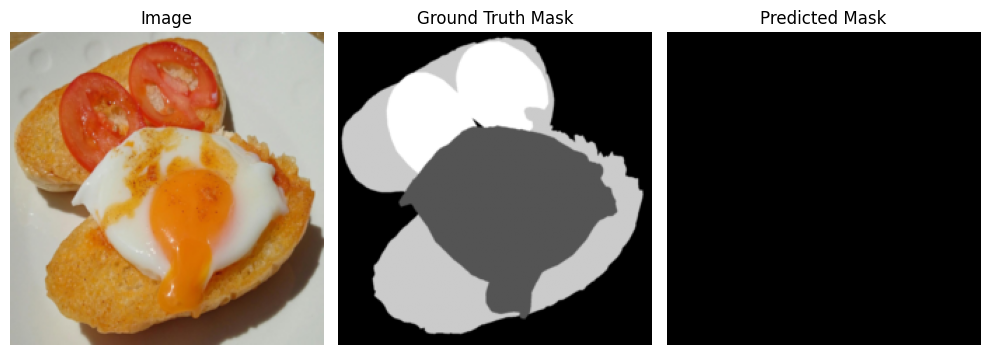

In [39]:
fig, axis = plt.subplots(1, 3, figsize=(10, 5))
axis[0].imshow(image)
axis[0].set_title("Image")
axis[0].axis('off')

axis[1].imshow(mask, cmap='gray')
axis[1].set_title("Ground Truth Mask")
axis[1].axis('off')

axis[2].imshow(predictions, cmap='gray')
axis[2].set_title("Predicted Mask")
axis[2].axis('off')

plt.tight_layout()
plt.show()